The 1D example in **Nonlocal flocking dynamics: Learning the fractional order of PDEs from particle simulations**, page 13

In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.special import gamma

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy import stats

In [3]:
seed = 0
dim = 1
bs = 1024

steps = 200
dt = 2/steps
alpha = 0.5
c = alpha * gamma((dim + alpha)/2) / (2 * np.pi** (alpha + dim/2) * gamma(1 - alpha/2))
np.random.seed(seed)

In [4]:
A = np.random.uniform(-0.75,0.75,(10000, dim))
B = np.random.uniform(0,1,(10000, dim))
mask = (B < np.cos(A * np.pi/1.5))[:,0]
C = A[mask]
C.shape

(6414, 1)

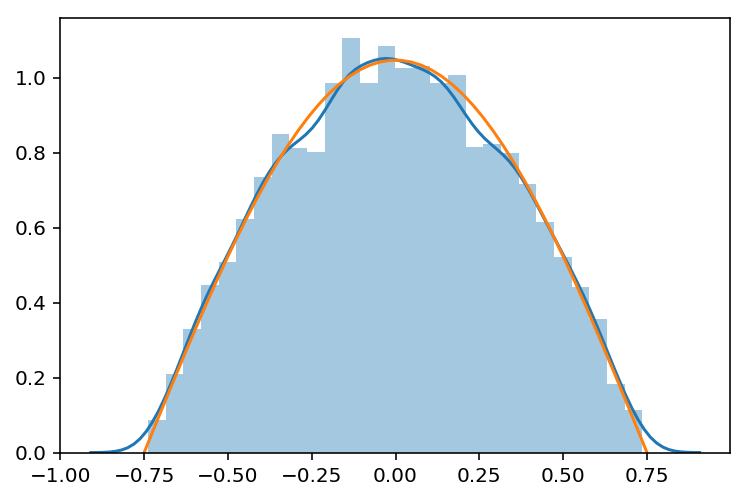

In [5]:
xx = np.linspace(-0.75,0.75)
sns.distplot(C)
plt.plot(xx, np.pi/3 * np.cos(xx * np.pi/ 1.5))

In [6]:
def phi(xi, xj):
    '''
    input: (bs, dim)
    return: (bs, dim)
    '''
    tol = 1e-3
    r = np.linalg.norm(xi - xj, axis = 1, keepdims = True)
    rr = np.clip(r, a_min = 1e-2, a_max = None)
    phi = c/(rr ** (dim+alpha))

    return phi

In [7]:
def acc(x, v):
    '''
    input: (bs, dim)
    return: (bs, dim)
    '''
    xi = np.reshape(np.tile(x[:,None,:], [1, bs, 1]), [-1, dim]) # (bs*bs, dim) [1,1,1,2,2,2,3,3,3]
    xj = np.reshape(np.tile(x[None,:,:], [bs, 1, 1]), [-1, dim]) # (bs*bs, dim) [1,2,3,1,2,3,1,2,3]
    vi = np.reshape(np.tile(v[:,None,:], [1, bs, 1]), [-1, dim]) # (bs*bs, dim) [1,1,1,2,2,2,3,3,3]
    vj = np.reshape(np.tile(v[None,:,:], [bs, 1, 1]), [-1, dim]) # (bs*bs, dim) [1,2,3,1,2,3,1,2,3]
    force = phi(xi, xj)*(vj - vi)
    a = np.sum(np.reshape(force, [bs,bs,dim]), axis = 1)/(bs-1) 
    return a

In [8]:
x = np.zeros([steps + 1, bs, dim])
v = np.zeros([steps + 1, bs, dim])
v2 = np.zeros([steps, bs, dim]) # v(t+0.5)
a = np.zeros([steps + 1, bs, dim])



x[0,...] = C[:bs]
v[0,...] = -0.5 * np.sin(np.pi * x[0,...]/1.5)
a[0,...] = acc(x[0, ...], v[0, ...])

In [9]:
for t in range(steps):
    if t %10 == 0:
        print(t, end = " ")
    v2[t] = v[t] + 0.5 * dt * a[t]
    x[t+1] = x[t] + dt * v2[t]
    a[t+1] = acc(x[t+1], v2[t])
    v[t+1] = v2[t] + 0.5 * dt * a[t+1]
    

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 

In [10]:
np.savez("ref_initrand_.npz", v = v, x = x)

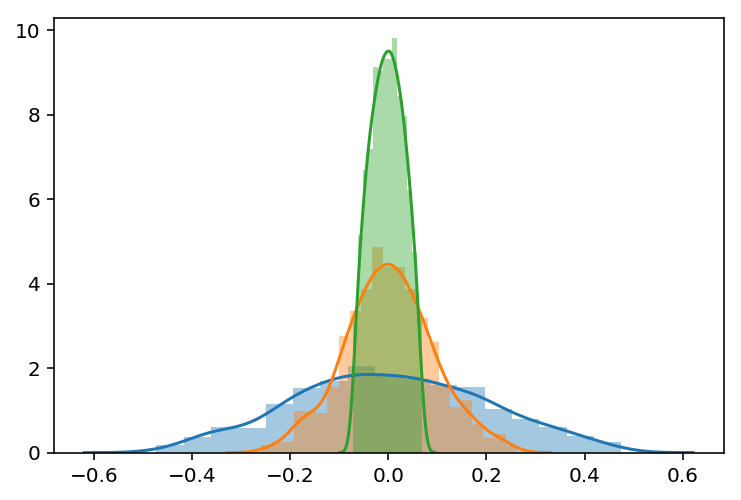

In [11]:
sns.distplot(x[50,:,0])
sns.distplot(x[100,:,0])
sns.distplot(x[200,:,0])